# Parameter-Effcient Fine-tuning with LoRA

In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn

In [47]:
import gc
import os
import random
import copy
import json

import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, TrainingArguments, Trainer
from datasets import load_dataset
import evaluate


seed = 42
random.seed(seed)
transformers.set_seed(seed)

import wandb

### Configuring W&B

In [3]:
# set the wandb project where this run will be logged
os.environ["WANDB_PROJECT"]="Parameter-Effcient Fine-tuning of GPT-2 with LoRA"

# save your trained model checkpoint to wandb
os.environ["checkpoint"]="true"

# turn off watch to log faster
os.environ["WANDB_WATCH"]="false"

In [4]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("wandb_api_key")

In [5]:
wandb.login(key=wandb_api_key)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: amiraaz to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Data Preprocessing

### Inits

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('openai-community/gpt2')
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
config = AutoConfig.from_pretrained('openai-community/gpt2')
model = AutoModelForCausalLM.from_pretrained('openai-community/gpt2', config=config)

In [ ]:
dataset = load_dataset('rajpurkar/squad')
vali_ds = dataset['validation'].select(range(5)) # select 5 examples for validation
split_ds = dataset['train'].train_test_split(test_size=0.1) # train_test_split with test_size=0.1
train_ds = split_ds['train'].shuffle().select(range(0, 2000))  # YOUR CODE HERE - select 2000 shuffled examples
eval_ds = split_ds['test'].shuffle().select(range(0, 200)) # select 200 shuffled examples

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

### Clearing Memory

In [9]:
del dataset, split_ds
gc.collect()

468

### Length Distribution of Sets
**note: extractive question-answering task**

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

def plot_seq_length_distibution(examples, type_plot):

    inputs = []
    for context, question, answers in zip(examples['context'], examples['question'], examples['answers']):
        answer_text = answers['text'][0]
        
        prompt = f"Context: {context}\nQuestion: {question}\nAnswer:"
        full_text = prompt + answer_text + tokenizer.eos_token
        
        inputs.append(full_text)
        
    tokenized_data = tokenizer(inputs)
    input_ids = tokenized_data['input_ids']

    lengths = [len(t_list) for t_list in input_ids]

    # Visualizing distro
    
    mu, sigma = np.mean(lengths), np.std(lengths)
    
    counts, bins, patches = plt.hist(
    lengths, 
    bins=50, 
    density=False, 
    alpha=0.6, 
    color='g', 
    label='Data Frequency'
)

    # Plot fitted normal distribution
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, sigma) * len(lengths) * (bins[1] - bins[0]) 
    plt.plot(x, p, 'k', linewidth=2, label=f'Normal Fit (μ={mu:.2f}, σ={sigma:.2f})')
    
    # Add labels/legend
    if type_plot == "train":
        title = 'Train Set Histogram'
    elif type_plot == 'valid':
        title = 'Validation Set Histogram'
    elif type_plot == 'eval':
        title = 'Evaluation Set Histogram'
    else:
        raise exception
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

    #stats
    return {
        'mean': mu,
        "std": sigma,
        'max': max(lengths),
        'min': min(lengths),
    }
    

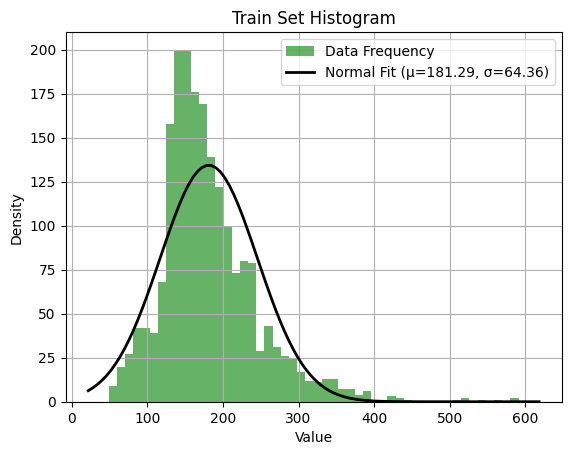

{'mean': 181.2875, 'std': 64.36031264490563, 'max': 591, 'min': 49}

In [11]:
plot_seq_length_distibution(train_ds, type_plot='train')

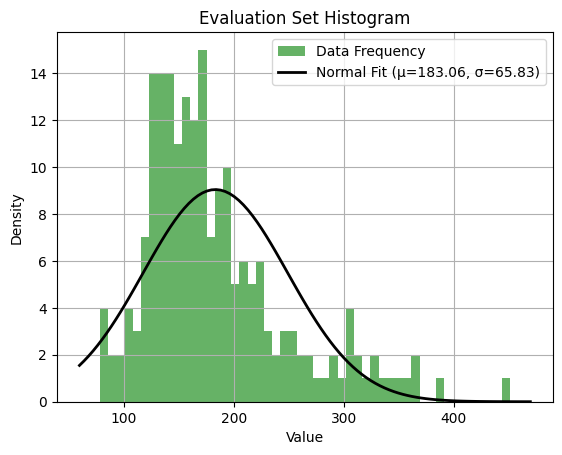

{'mean': 183.065, 'std': 65.83191304375106, 'max': 451, 'min': 78}

In [12]:
plot_seq_length_distibution(eval_ds, type_plot='eval')

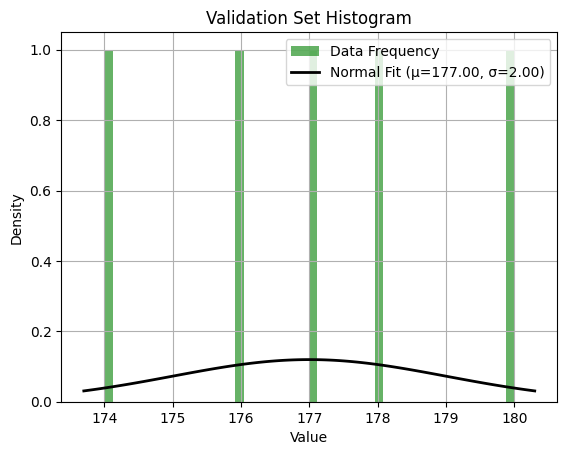

{'mean': 177.0, 'std': 2.0, 'max': 180, 'min': 174}

In [13]:
plot_seq_length_distibution(vali_ds, type_plot='valid')

### Preprocessing Function Definition

In [ ]:
def preprocess_function(examples):
    """
    Creates properly aligned input-label pairs for causal LM fine-tuning
    
    Args:
        examples: Batch of SQuAD examples with 'context', 'question', 'answers'
    
    Returns:
        Dictionary with 'input_ids', 'attention_mask', 'labels'
    """
    inputs = []
    targets = []
    
    for context, question, answers in zip(examples['context'], examples['question'], examples['answers']):
        answer_text = answers['text'][0]
        
        prompt = f"Context: {context}\nQuestion: {question}\nAnswer:"
        full_text = prompt + answer_text + tokenizer.eos_token
        
        inputs.append(full_text)
    
    model_inputs = tokenizer(inputs, max_length=300, truncation=True, padding='longest')
    
    labels = []
    for i, input_ids in enumerate(model_inputs['input_ids']):
        # YOUR CODE HERE: Create label_ids, find prompt_length, mask prompt tokens
        label_ids = list(input_ids)
        
        c = examples['context'][i]
        q = examples['question'][i]
        
        prompt = f"Context: {c}\nQuestion: {q}\nAnswer:"
        tokenized_prompt = tokenizer(prompt, max_length=300, truncation=True)
        prompt_length = len(tokenized_prompt['input_ids'])

        for j in range(prompt_length):
            if j < len(label_ids):
                label_ids[j] = -100
                
        labels.append(label_ids)
    
    model_inputs['labels'] = labels


    return model_inputs

## Custom Data Collation

In [ ]:
class QADataCollator:
    """
    Custom data collator for QA fine-tuning with proper padding
    """
    def __init__(self, tokenizer, max_length=256):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_pad_token_id = -100 
    def __call__(self, features):
        input_ids = [feautre["input_ids"] for feautre in features]
        attention_mask = [feautre["attention_mask"] for feautre in features]
        labels = [feautre["labels"] for feautre in features]

        # Counting maximum length for the current batch
        batch_max_length = min(max(len(ids) for ids in input_ids), self.max_length)

        tokenized_batch = self.tokenizer.pad(
            [{'input_ids': ids, 'attention_mask': mask} for ids, mask in zip(input_ids, attention_mask)],
            padding='longest', 
            max_length=self.max_length,
            return_tensors='pt',            
        )

        
        # Using -100 for labels
        padded_labels = []
        for label in labels:
            if len(label) > batch_max_length:
                # Truncatting
                padded_labels.append(label[:batch_max_length])
            elif len(label) < batch_max_length:
                # Padding with -100
                padded_labels.append(label + [self.label_pad_token_id] * (batch_max_length - len(label)))
            else:
                padded_labels.append(label)
        
        tokenized_batch['labels'] = torch.tensor(padded_labels, dtype=torch.long)
        return tokenized_batch

In [ ]:
tok_train_ds = train_ds.map(
    preprocess_function,
    batched=True, 
    remove_columns=train_ds.column_names,
    num_proc=4
)

tok_eval_ds = eval_ds.map(
    preprocess_function,
    batched=True,
    remove_columns=eval_ds.column_names,
    num_proc=4
)


print(f"Training examples: {len(tok_train_ds)}")
print(f"Eval examples: {len(tok_eval_ds)}")

Map (num_proc=4):   0%|          | 0/2000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/200 [00:00<?, ? examples/s]

Training examples: 2000
Eval examples: 200


In [17]:
tok_train_ds.save_to_disk("./processed_data/tok_train_ds")
tok_eval_ds.save_to_disk("./processed_data/tok_eval_ds")
!zip -r -q processed_data.zip processed_data

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

In [18]:
# from datasets import load_from_disk
# tok_train_ds = load_from_disk("/kaggle/input/sqaud-processed-data/processed_data/tok_train_ds")
# tok_eval_ds = load_from_disk("/kaggle/input/sqaud-processed-data/processed_data/tok_eval_ds")

## LoRA Conguration and Training

### Importations

In [19]:
from peft import LoraConfig, TaskType, get_peft_model
from torchinfo import summary

### GPT2 Model Structure

#### Overall Structure

In [ ]:
summary(model.transformer)

#### Single GPT Block

In [ ]:
summary(model.transformer.h[0])

### Freezing the model

In [ ]:
for param in model.parameters():
    param.requires_grad = False

### Setting LoRA Hyperparams

In [ ]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32, 
    target_modules=['c_attn', 'c_proj'],
    lora_dropout=0.05,
    bias='none',
    task_type=TaskType.CAUSAL_LM
)

### Lora Model Making

In [ ]:
lora_model = get_peft_model(model, lora_config)
lora_model.print_trainable_parameters()

In [ ]:
# Verify LoRA setup
for name, param in lora_model.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")

In [ ]:
data_collator = QADataCollator(tokenizer, max_length=300)

### Setting up Trainer Args

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./lora_qa_finetuned_model/E1", # Directory to save checkpoints and outputs
    per_device_train_batch_size=8, # Batch size per GPU/CPU for training
    gradient_accumulation_steps=2, # Accumulate gradients over 2 steps ?
    per_device_eval_batch_size=8, # Batch size per GPU/CPU for evaluation
    learning_rate=2e-4, # Initial learning rate for AdamW optimizer
    num_train_epochs=10, # Total number of training epochs
    logging_steps=50, # Log training metrics every 50 steps
    save_steps=500, # Save checkpoint every 500 steps
    
    eval_strategy="steps", # Evaluate every 'eval_steps'
    eval_steps=500, # Perform evaluation every 500 steps
    warmup_steps=100, # Number of warmup steps for learning rate scheduler
    lr_scheduler_type="cosine", # Type of learning rate scheduler
    report_to="wandb", # Don't report to any external logging tool by default
    push_to_hub=False, # Do not push model to Hugging Face Hub
    fp16=torch.cuda.is_available(), # Use mixed precision training if CUDA is available
    load_best_model_at_end=True, # Load the best model at the end of training based on eval_loss
    metric_for_best_model="eval_loss", # Metric to determine the best model
    greater_is_better=False, # Smaller eval_loss is better
)

In [ ]:
lora_model.train()

trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=tok_train_ds,
    eval_dataset=tok_eval_ds,
    data_collator=data_collator,
)

In [ ]:
print("Starting training...")
trainer.train()

wandb.finish()

## Inference and Evaluation

### Evaluating the model

In [ ]:
evaluation_result = trainer.evaluate()
print("Evaluation results:", evaluation_result)

wandb.finish()

### Saving the model and tokenizer

In [ ]:
lora_model.save_pretrained(training_args.output_dir)
tokenizer.save_pretrained(training_args.output_dir)

### Testing

In [ ]:
def generate_answer(model, tokenizer, context, question, max_new_tokens=50, generation_strategy="greedy", top_k=50, top_p=0.9, temperature=1.0):
    """
    Generate answer for a given context and question
    """
    model.eval()
    
    prompt = f"Context: {context}\nQuestion: {question}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt", max_length=300, truncation=True)
    
    input_ids = inputs["input_ids"].to(model.device)
    attention_mask = inputs["attention_mask"].to(model.device)

    # Determine generation parameters
    generation_kwargs = {
        "max_new_tokens": max_new_tokens,
        "pad_token_id": tokenizer.pad_token_id,
        "eos_token_id": tokenizer.eos_token_id,
        "attention_mask": attention_mask,
    }

    if generation_strategy == "greedy": 
        generation_kwargs["do_sample"] = False
        
    elif generation_strategy == "top_k": 
        generation_kwargs["do_sample"] = True
        generation_kwargs["top_k"] = top_k
        generation_kwargs["temperature"] = temperature
        
    elif generation_strategy == "nucleus": 
        generation_kwargs["do_sample"] = True
        generation_kwargs["top_p"] = top_p
        generation_kwargs["temperature"] = temperature
        
    else:
        generation_kwargs["do_sample"] = True
        generation_kwargs["temperature"] = temperature


    # Generate the output sequence
    output_sequences = model.generate(input_ids, **generation_kwargs)

    # Decode the output
    generated_text = tokenizer.decode(output_sequences[0], skip_special_tokens=False) # Keepping EOS toekn becuase splition is based on this.

    # Extract only the answer part
    prompt_len_chars = len(prompt)
    if generated_text.startswith(prompt):
        answer_start_index = prompt_len_chars
        answer = generated_text[answer_start_index:].strip()

        # Remove the <|endoftext|> (eos_token) if it's at the end of the answer
        if answer.endswith(tokenizer.eos_token):
            answer = answer[:-len(tokenizer.eos_token)].strip()
    else:
        # Fallback if the generated text doesn't exactly start with the prompt (e.g., due to truncation)
        # This is less ideal but provides a fallback.
        print("Warning: Generated text did not start with the prompt as expected. Attempting heuristic extraction.")
        try:
            answer_tag_index = generated_text.rfind("Answer:") # Find last occurrence of "Answer:"
            if answer_tag_index != -1:
                answer = generated_text[answer_tag_index + len("Answer:"):].strip()
                if answer.endswith(tokenizer.eos_token):
                    answer = answer[:-len(tokenizer.eos_token)].strip()
            else:
                answer = generated_text # If "Answer:" not found, return full generated text
        except Exception:
            answer = generated_text

    return answer

In [ ]:
from peft import AutoPeftModelForCausalLM
ft_model = AutoPeftModelForCausalLM.from_pretrained(training_args.output_dir, torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32)

In [ ]:
print("\n=== Testing Fine-tuned Model ===")
for i, example in enumerate(vali_ds):   
    if i >= 3: # Test on first 3 validation examples
        break

    context = example['context']
    question = example['question']
    ground_truth_answers = example['answers']['text']
    print(f'----start of {i}----')
    # Generating answer using the fine-tuned model
    current_prediction = generate_answer(ft_model, tokenizer, context, question, generation_strategy="greedy")
    # current_prediction = generate_answer(ft_model, tokenizer, context, question, generation_strategy="top_k", top_k=50)
    # current_prediction = generate_answer(ft_model, tokenizer, context, question, generation_strategy="nucleus", top_p=0.9)


    print(f"\nExample {i+1}:")
    print(f"  Context: {context[:100]}...") # Print first 100 chars of context
    print(f"  Question: {question}")
    print(f"  Ground Truth: {ground_truth_answers}")
    print(f"  Prediction: {current_prediction}")

In [ ]:
predictions = []
references = []

# Loop through validation dataset
for example in vali_ds:
    context = example['context']
    question = example['question']
    ground_truth_answers = example['answers']['text']

    # Generate prediction (using greedy for consistent evaluation)
    predicted_answer = generate_answer(ft_model, tokenizer, context, question, generation_strategy="greedy")

    predictions.append({
        'prediction_text': predicted_answer,
        'id': example['id'] # SQuAD metric requires the example ID
    })
    references.append({
        'answers': {
            'text': ground_truth_answers,
            'answer_start': example['answers']['answer_start']
        },
        'id': example['id']
    })

In [ ]:
try:
    squad_metric = evaluate.load("squad")
    results = squad_metric.compute(predictions=predictions, references=references)
    print(f"\nSQuAD Metrics: {results}")
except Exception as e:
    print(f"Could not load SQuAD metric: {e}")
    print("Install with: pip install evaluate datasets[metrics]")

## Experiments

In [52]:
config = AutoConfig.from_pretrained('openai-community/gpt2')
model = AutoModelForCausalLM.from_pretrained('openai-community/gpt2', config=config)

for param in model.parameters():
    param.requires_grad = False

data_collator = QADataCollator(tokenizer, max_length=300)
global_squad_metric = evaluate.load("squad")

In [39]:
experiment_results = []

In [ ]:
for r in [4, 8, 16, 32]:
    for target_module in [['c_attn'], ['c_attn', 'c_proj']]:
        for lr in ["1e-4", "2e-4", "5e-4"]:
            if len(target_module) > 1:
                tar = 'attention_MLP'
            else:
                tar = "attention"

            run_name = f'LoRA_r{r}_lr{lr}_{tar}'
            save_dir = os.path.join("./lora_qa_finetuned_model", run_name) 

            print(f"----------- Starting Experiment with config: {run_name} ----------- ")
            print(f'Save path: {save_dir}\n')
            
            model = copy.deepcopy(model)

            lora_config = LoraConfig(
                r=r,
                lora_alpha=32, 
                target_modules=target_module,
                lora_dropout=0.05,
                bias='none',
                task_type=TaskType.CAUSAL_LM
            )

            lora_model = get_peft_model(model, lora_config)
            lora_model.print_trainable_parameters()

            trainable_params_count = lora_model.get_nb_trainable_parameters()
            print(f"\n\nCaptured Trainable Parameters: {trainable_params_count}")

            training_args = TrainingArguments(
            output_dir=save_dir, # Directory to save checkpoints and outputs
            per_device_train_batch_size=8, # Batch size per GPU/CPU for training
            gradient_accumulation_steps=2, # Accumulate gradients over 2 steps ?
            per_device_eval_batch_size=8, # Batch size per GPU/CPU for evaluation
            learning_rate=float(lr), # Initial learning rate for AdamW optimizer
            num_train_epochs=15, # Total number of training epochs
            logging_steps=50, # Log training metrics every 50 steps
            save_steps=500, # Save checkpoint every 500 steps
            
            eval_strategy="steps", # Evaluate every 'eval_steps'
            eval_steps=500, # Perform evaluation every 500 steps
            warmup_steps=100, # Number of warmup steps for learning rate scheduler
            lr_scheduler_type="cosine", # Type of learning rate scheduler
            report_to="wandb", # Don't report to any external logging tool by default
            run_name=run_name,
            push_to_hub=False, # Do not push model to Hugging Face Hub
            fp16=torch.cuda.is_available(), # Use mixed precision training if CUDA is available
            load_best_model_at_end=True, # Load the best model at the end of training based on eval_loss
            metric_for_best_model="eval_loss", # Metric to determine the best model
            greater_is_better=False, # Smaller eval_loss is better
        )

            lora_model.train()
            
            trainer = Trainer(
                model=lora_model,
                args=training_args,
                train_dataset=tok_train_ds,
                eval_dataset=tok_eval_ds,
                data_collator=data_collator,
            )
            print('Starting Training...')
            trainer_output = trainer.train()
    
            training_runtime_seconds = trainer_output.metrics.get("train_runtime", None)
            if training_runtime_seconds is not None:
                print(f"Training runtime for {run_name}: {training_runtime_seconds:.2f} seconds")
            
            lora_model.save_pretrained(training_args.output_dir)
            tokenizer.save_pretrained(training_args.output_dir)
    
            # Evaluation
            ft_model_for_eval = trainer.model
            ft_model_for_eval.eval()
    
            predictions = []
            references = []
    
            
            for i, example in enumerate(vali_ds):
                print(f'Example number: {i}')
                context = example['context']
                question = example['question']
                ground_truth_answers = example['answers']['text']
    
                predicted_answer = generate_answer(ft_model_for_eval, tokenizer, context, question, generation_strategy="greedy", max_new_tokens=50)
    
                predictions.append({
                    'prediction_text': predicted_answer,
                    'id': example['id']
                })
                references.append({
                    'answers': {
                        'text': ground_truth_answers,
                        'answer_start': example['answers']['answer_start']
                    },
                    'id': example['id']
                })
    
            try:
                final_squad_results = global_squad_metric.compute(predictions=predictions, references=references)
                print(f"\nFinal SQuAD Metrics for {run_name}: {final_squad_results}")
    
                if wandb.run is not None:
                    wandb_log_dict = {
                            "final_squad_f1": final_squad_results["f1"],
                            "final_squad_exact_match": final_squad_results["exact_match"],
                            "best_eval_loss": trainer.state.best_metric,
                            "trainable_parameters": trainable_params_count[0],
                        }
                    if training_runtime_seconds is not None:
                        wandb_log_dict["train_runtime_seconds"] = training_runtime_seconds
                    wandb.log(wandb_log_dict)
                    print(f"Final SQuAD and best eval loss metrics logged to WandB for run {wandb.run.name}.")
    
                experiment_result_entry = {
                        "r": r,
                        "lr": float(lr),
                        "target_modules": tar,
                        "f1": final_squad_results["f1"],
                        "exact_match": final_squad_results["exact_match"],
                        "eval_loss": trainer.state.best_metric,
                        "trainable_parameters": trainable_params_count[0],
                    }
                if training_runtime_seconds is not None:
                    experiment_result_entry["train_runtime_seconds"] = training_runtime_seconds
                    
                experiment_results.append(experiment_result_entry)
    
            except Exception as e:
                print(f"Error computing or logging SQuAD metric for {run_name}: {e}")
    
            wandb.finish()


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


----------- Starting Experiment with config: LoRA_r4_lr1e-4_attention ----------- 
Save path: ./lora_qa_finetuned_model/LoRA_r4_lr1e-4_attention

trainable params: 405,504 || all params: 124,845,312 || trainable%: 0.3248


Captured Trainable Parameters: (405504, 124845312)
Starting Training...


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
os.makedirs("plots", exist_ok=True)

In [64]:
json_output_path = os.path.join("plots", "experiment_results.json")
with open(json_output_path, 'w') as f:
    json.dump(experiment_results, f, indent=4)
print(f"\nExperiment results saved to {json_output_path}")

[{'r': 4,
  'lr': '1e-4',
  'target_modules': 'attention',
  'f1': 0.0,
  'exact_match': 0.0,
  'eval_loss': None,
  'trainable_parameters': (147456, 124587264),
  'train_runtime_seconds': 132.4958},
 {'r': 4,
  'lr': '1e-4',
  'target_modules': 'attention_MLP',
  'f1': 60.0,
  'exact_match': 60.0,
  'eval_loss': None,
  'trainable_parameters': (405504, 124845312),
  'train_runtime_seconds': 141.292},
 {'r': 4,
  'lr': 0.0001,
  'target_modules': 'attention',
  'f1': 60.0,
  'exact_match': 60.0,
  'eval_loss': None,
  'trainable_parameters': (405504, 124845312),
  'train_runtime_seconds': 141.4075}]